In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import cv2
import sys

In [6]:
def read_flo(filename):
    """Read a .flo optical flow file in Middlebury format."""
    with open(filename, 'rb') as f:
        magic = struct.unpack('f', f.read(4))[0]
        if magic != 202021.25:
            raise ValueError("Invalid .flo file: wrong magic number")
        w = struct.unpack('i', f.read(4))[0]
        h = struct.unpack('i', f.read(4))[0]
        data = np.fromfile(f, np.float32, count=2*w*h)
        flow = np.resize(data, (h, w, 2))
        return flow

def flow_to_color(flow, max_flow=None):
    """Convert flow to RGB image using HSV color encoding."""
    u, v = flow[..., 0], flow[..., 1]

    rad = np.sqrt(u**2 + v**2)
    angle = np.arctan2(-v, -u) / np.pi

    if max_flow is None:
        max_flow = np.percentile(rad, 99)  # robust normalization
    rad = np.clip(rad / max_flow, 0, 1)

    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.float32)
    hsv[..., 0] = (angle + 1) / 2  # hue [0,1]
    hsv[..., 1] = 1.0              # saturation
    hsv[..., 2] = rad              # value = magnitude

    rgb = cv2.cvtColor((hsv * 255).astype(np.uint8), cv2.COLOR_HSV2RGB)
    return rgb


def quiver_plot(flow, stride=10, scale=0.5, scale_label="10 px/frame"):
    """Plot a quiver plot of the flow field with a visible scale bar."""
    h, w = flow.shape[:2]
    y, x = np.mgrid[0:h:stride, 0:w:stride]
    u = flow[::stride, ::stride, 0]
    v = -flow[::stride, ::stride, 1]  # flip Y for display

    fig, ax = plt.subplots(figsize=(12, 10))
    q = ax.quiver(x, y, u, v, color='red', angles='xy',
                  scale_units='xy', scale=scale, pivot='middle')

    # Add a quiverkey (scale bar) in bottom left corner
    ax.quiverkey(q, X=0.1, Y=-0.1, U=10,
                 label=scale_label, labelpos='E', coordinates='axes')

    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_title("Optical Flow Quiver Plot")
    plt.show()

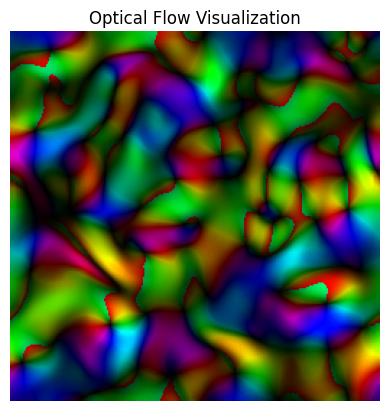

In [15]:
#fname = "./images/demo/DemoOutput/PIV-LiteFlowNet-en/-0_2/flow/0798_out.flo"
fname = "./images/demo/DemoOutput/PIV-LiteFlowNet-en/-0_2/flow/DNS_turbulence_img1_out.flo"
flow = read_flo(fname)
rgb = flow_to_color(flow)

# Show image
plt.imshow(rgb)
plt.title("Optical Flow Visualization")
plt.axis("off")
plt.show()

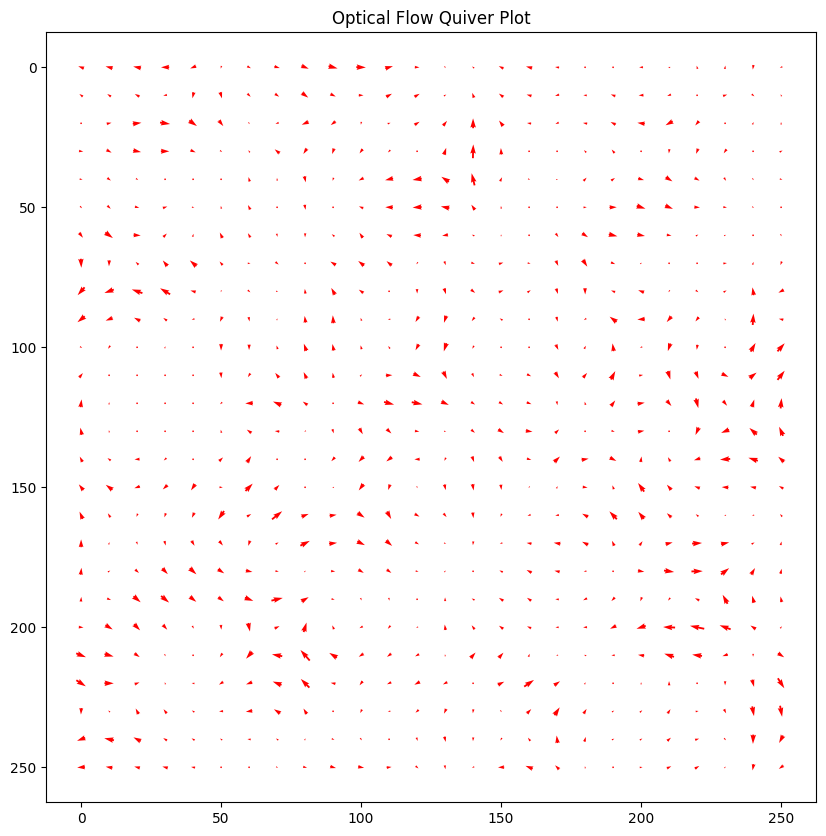

In [13]:
quiver_plot(flow)